In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os.path as osp
import xarray as xr
import sys
import os
import glob
import pickle5 as pickle
import yaml
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import cascaded_union
import imageio

import utils

# Individual-Based Model Results
### Properties of simulated birds
 - initial position ($p_0$, randomly sampled from specified departure area)
 - date at which migration is initiated
 - preferred migration direction ($\alpha_{pref}$, sampled from wrapped Gaussian distribution with $mean=215^{\circ}$ and $std=5^{\circ}$)
 - air speed ($v_{air}=10 \ m/s$)
 - wind compensation $f_{wind}\in \left[0,1\right]$
 - tolerated energy expenditure per unit distance travelled along the preferred migration direction ($e_{tol}$ sampled from Gaussian distribution)
 - state (one of 'flying', 'landed', 'outside simulated area')

Air speed and wind compensation are the same for all simulated birds.

### Environmental variables
 - wind at $850mb$
 - sun position

### Dynamics
The trajectories of $N$ birds are simulated with a time resolution of 1 hour. <br>
At each time step, birds choose their next state based on their previous state and the environmental conditions at that time.

#### Departure
Birds decide to take off if all of the followind conditions are met:
 - it is the first hour after civil dusk (sun position $< -6^{\circ}$)
 - the bird has initiated its migration
 - the energy expenditure given the wind contitions, the bird's preferred direction and wind compensation is lower than the birds threshold $e_{tol}$
 - the wind conditions allow for the desired amount of compensation

Energy expenditure is computed as

$e = \frac{v_{air}}{v_{ground} * \cos(\gamma)} - 1$, with $\gamma$ the drift angle 

#### Flight behavior
For a flying bird the next position is computed as follows:

$p_{t+1} = p_{t} + \mathbf{v}_{ground}$,

with $\mathbf{v}_{ground}$ the ground speed vector with 
 - length $v_{ground} = v_{air} * \cos(\alpha_{head} - \gamma + v_{wind} * \cos(\beta - \gamma)$, <br> with $\alpha_{head}$ the bird's heading, $\beta$ the wind direction and $\gamma$ the drift angle, all given relative to the preferred direction of the bird $\alpha_{pref}$
 - direction $\alpha_{res} = \alpha_{pref} + \gamma$

The bird's heading and drift are computed as follows:
 - $\alpha_{head} = -\arcsin(\frac{f_{wind}*v_{wind}*\sin(\beta)}{v_{air}})$
 - $\gamma = \arctan(\frac{v_{air} * \sin(\alpha_{head}) + v_{wind} * \sin(\beta)}{v_{air} * \cos(\alpha_{head}) + v_{wind} * \cos(\beta)})$


### Load shape data

In [2]:
d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
departure_area = gpd.read_file(osp.join(d, 'departure_area.shp'))
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
sink = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi_sink.shp').to_crs(epsg='4326')
voronoi_with_sink = utils.add_sink_to_voronoi(voronoi, sink)

# crs for equal area transformation
crs_proj4 = ccrs.AlbersEqualArea().proj4_init

### Load Simulation Data

In [3]:
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2015/experiment_2021-02-19 15:13:36.750872'
#abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2015'
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2017/experiment_2021-03-26 12:50:21.974065/'
traj, states, time = utils.load_sim_results(abm_path)
T = len(time)
with open(osp.join(abm_path, 'abm_config.yml')) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
# simulation settings
print('Simulation Settings')
print('-'*40)
print(f'start date: {config["year"]}-{config["start_date"]}')
print(f'end date:   {config["year"]}-{config["end_date"]}')
print(f'number of birds: {config["num_birds"]}')
print(f'wind compensation: {config["settings"]["compensation"]*100}%')
print(f'tolerated energy expenditure: {config["settings"]["energy_tol_mean"]} +/- {config["settings"]["energy_tol_std"]}')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### Plot Example Trajectories

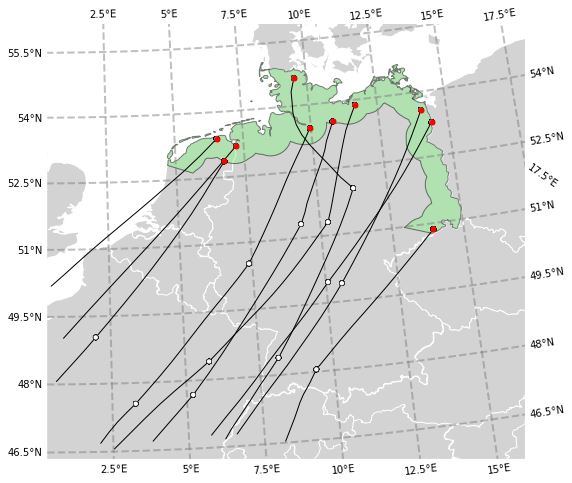

In [8]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
utils.plot_trajectories(ax, countries, departure_area, traj, states, birds=range(10))
#ax.set_title('example trajectories', fontsize=20);

### Aggregate Trajectories into Bird Densities

In [111]:
# radar area counts [air]
radars = [Point(row.x, row.y).buffer(25_000) for i, row in voronoi.iterrows()]
radars = gpd.GeoDataFrame({'radar': voronoi['radar'], 'geometry': radars}, crs='epsg:3035')
radars = radars.to_crs(epsg='4326')

counts_rad, names_rad = utils.aggregate(traj, states, radars, range(T), state=1)
counts_rad = counts_rad.fillna(0)
rad_areas = radars.to_crs(crs_proj4).area

In [104]:
# voronoi cell counts [air]
counts_vor, names_vor = utils.aggregate(traj, states, voronoi, range(T), state=1)
counts_vor = counts_vor.fillna(0)
vor_areas = voronoi.to_crs(crs_proj4).area

In [105]:
# voronoi cell counts [ground]
counts_vor_gr, _ = utils.aggregate(traj, states, voronoi, range(T), state=0)
counts_vor_gr = counts_vor_gr.fillna(0)

#### Total Bird Counts per Hour

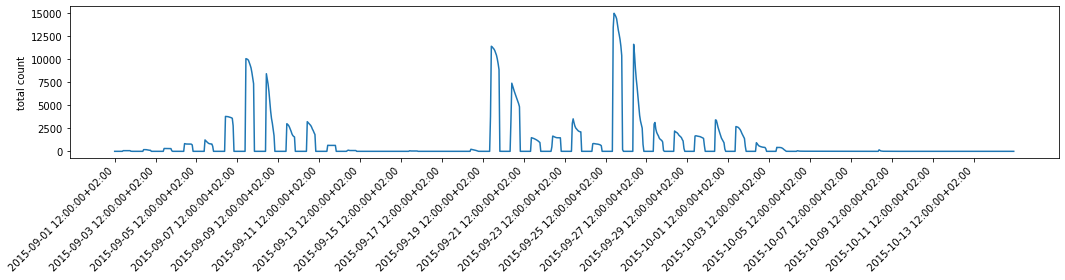

In [12]:
t_range = np.arange(T)
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(t_range, [counts_vor[f'n_birds_{t}'].sum() for t in t_range])
ax.set(ylabel='total count')
plt.xticks(t_range[::48], time[:stop:48], rotation=45, ha='right');
fig.tight_layout()

#### Bird Counts per Voronoi Cell per Hour

mean deviation from true bird counts: 29.938098386596216 +/- 420.8301147288418


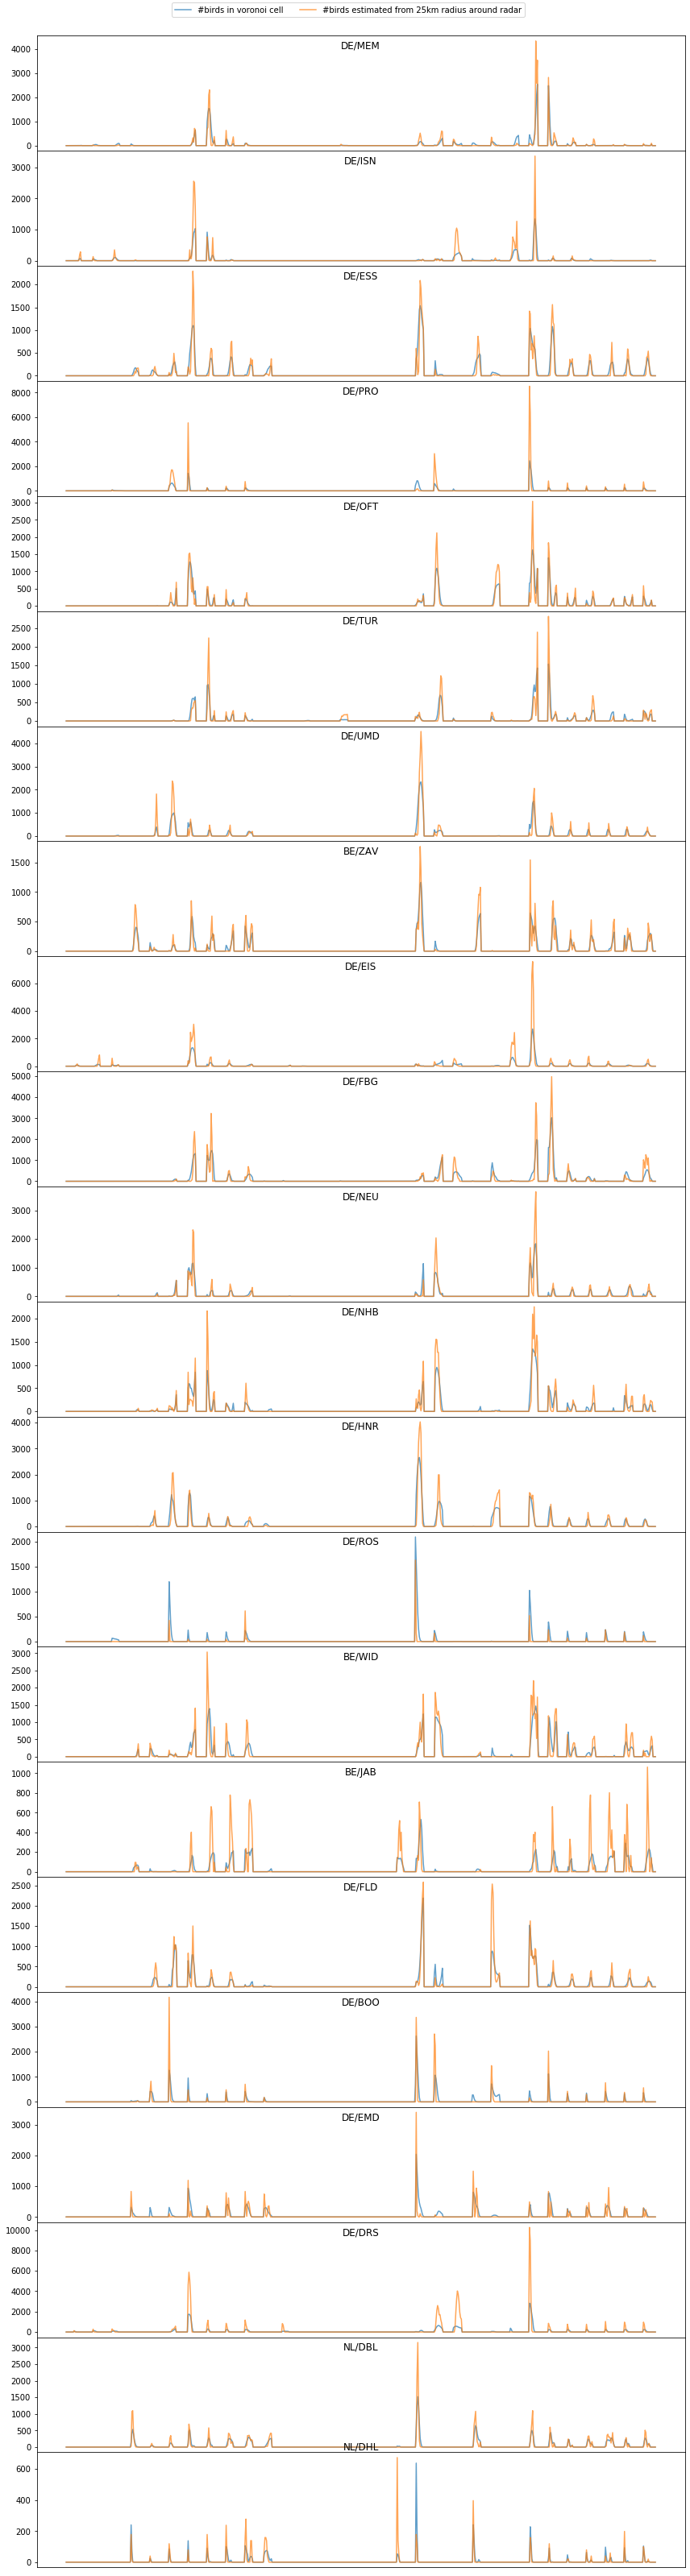

In [124]:
t_range = range(T)[:-24*30]
n_radars = len(radars)
fig, ax = plt.subplots(n_radars, 1, figsize=(12,n_radars*2), sharex=True)
labels = ['#birds in voronoi cell', '#birds estimated from 25km radius around radar']
all_diff = []
for i in range(n_radars):
    vor = [counts_vor.iloc[i][f'n_birds_{t}'] for t in t_range]
    rad = [(counts_rad.iloc[i][f'n_birds_{t}'] / rad_areas.iloc[i]) * vor_areas.iloc[i] for t in t_range]
    
    idx = np.where(np.array(vor) > 0)
    all_diff.extend(np.array(rad)[idx]-np.array(vor)[idx])
    
    if i == n_radars-1:
        ax[i].plot(t_range, vor, alpha=0.7, label=labels[0])
        ax[i].plot(t_range, rad, alpha=0.7, label=labels[1])
        ax[i].set_xticklabels(time)
    else:
        ax[i].plot(t_range, vor, alpha=0.7)
        ax[i].plot(t_range, rad, alpha=0.7)
        ax[i].set_xticks([])
    ax[i].set_title(counts_vor.iloc[i].radar, pad=-16)
    
fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.01))
fig.tight_layout()
fig.subplots_adjust(hspace=0)

print(f'mean deviation from true bird counts: {np.mean(all_diff):} +/- {np.std(all_diff)}')

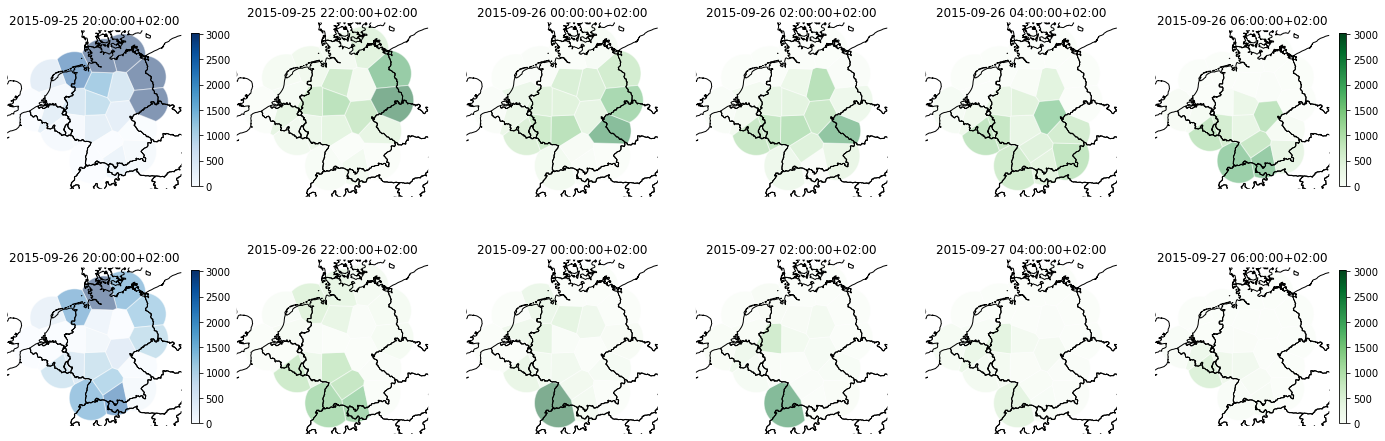

In [127]:
extent = [0.36, 46.36, 16.07, 55.40]
n_start = [128 + 19*24, 152 + 19*24]
num_t = 6

vmin = counts_vor[names_vor].min().min()
vmax = counts_vor[names_vor].max().max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_gr = mpl.cm.ScalarMappable(norm=norm, cmap='Greens').cmap
cmap_bl = mpl.cm.ScalarMappable(norm=norm, cmap='Blues').cmap

fig, axes = plt.subplots(len(n_start), num_t, figsize=(num_t*4, 8), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
for i, start in enumerate(n_start):
    t_range = [start + dt*2 for dt in range(num_t)]
    for j, tidx in enumerate(t_range):
        legend=True if tidx == t_range[-1] else False
            
        axes[i,j].set_title(time[tidx])
        axes[i,j] = gplt.polyplot(countries, ax=axes[i,j], edgecolor="black", extent=extent, zorder=1)
        if j==0:
            q = counts_vor_gr
            cm = cmap_bl
            legend=True
        else:
            q = counts_vor
            cm = cmap_gr       
        gplt.choropleth(q, hue=names_vor[tidx], edgecolor='white', linewidth=1, ax=axes[i,j], alpha=0.5, zorder=0,
            cmap=cm, norm=norm, extent=extent, legend=legend, legend_kwargs={'fraction': 0.04} if legend else {});

### Determine Flows between Voronoi Cells

#### Theoretical estimate of max outflux per voronoi cell
Estimated maximal ground speed: $v_{max}=20 \ m/s = 72 \ km/h$ <br>
A slightly more conservative estimate would be: $v_{max}=15 \ m/s = 54 \ km/h$
With no wind (and considering the different flight directions along the boundary), taking the air speed would be more reasonable: $v_{max}=10 \ m/s = 36 \ km/h$

This means that only birds located in the $v_{max}$ margin from the voronoi cell boundary can move to adjacent cells.<br>
This gives the following estimates of the maximal relative outflux per cell:

In [125]:
voronoi_eqa = voronoi.to_crs(crs_proj4)
margin_72 = voronoi_eqa.difference(voronoi_eqa.buffer(-72_000))
margin_54 = voronoi_eqa.difference(voronoi_eqa.buffer(-54_000))
margin_36 = voronoi_eqa.difference(voronoi_eqa.buffer(-36_000))
voronoi['max_outflux_72'] = margin_72.area / voronoi_eqa.area
voronoi['max_outflux_54'] = margin_54.area / voronoi_eqa.area
voronoi['max_outflux_36'] = margin_36.area / voronoi_eqa.area
voronoi[['radar', 'max_outflux_72', 'max_outflux_54', 'max_outflux_36']]

,radar,max_outflux_72,max_outflux_54,max_outflux_36
0,DE/MEM,0.988261,0.880765,0.679184
1,DE/ISN,0.900483,0.759123,0.560530
2,DE/ESS,1.000000,0.931139,0.725113
3,DE/PRO,0.870392,0.725225,0.531465
4,DE/OFT,0.985318,0.878207,0.672834
5,DE/TUR,1.000000,0.953318,0.745867
6,DE/UMD,0.990266,0.879167,0.668257
7,BE/ZAV,1.000000,0.979528,0.806594
8,DE/EIS,0.963396,0.829686,0.617943
9,DE/FBG,0.828701,0.681630,0.494265


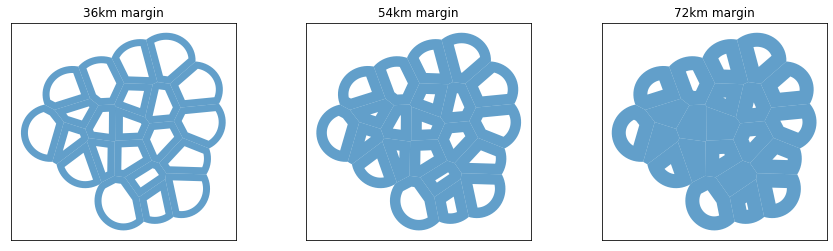

In [126]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
gpd.GeoSeries(margin_36, crs=crs_proj4).plot(ax=ax[0], alpha=0.7)
ax[0].set(xticks=[], yticks=[], title='36km margin');
gpd.GeoSeries(margin_54, crs=crs_proj4).plot(ax=ax[1], alpha=0.7)
ax[1].set(xticks=[], yticks=[], title='54km margin')
gpd.GeoSeries(margin_72, crs=crs_proj4).plot(ax=ax[2], alpha=0.7)
ax[2].set(xticks=[], yticks=[], title='72km margin');

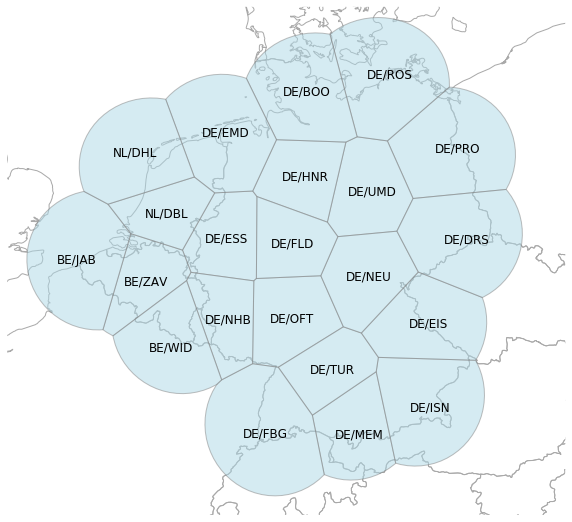

In [91]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
gplt.polyplot(countries, ax=ax, edgecolor="darkgray", extent=extent, zorder=1)
gplt.polyplot(voronoi, ax=ax, edgecolor="gray", facecolor='lightblue', alpha=0.5, extent=extent, zorder=2)

centroids = voronoi.to_crs(crs_proj4).centroid

for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, voronoi.radar):
    ax.annotate(label, xy=(x, y), xytext=(-20, -5), textcoords="offset points", fontsize=12);

In [ ]:
tidx = n_start[0]+4
print(time[tidx])
flows = utils.get_bird_flows(traj, states, tidx, voronoi_with_sink)

In [12]:
groups = flows.groupby('radar')
grouped = groups['dst_radar'].value_counts()

for src, dst in groups:
    print(f'outflux for radar {src}')
    z = dst['dst_radar'].value_counts().sum()
    print(dst['dst_radar'].value_counts() / z, '\n')

outflux for radar BE/JAB
BE/JAB    1.0
Name: dst_radar, dtype: float64 

outflux for radar BE/WID
BE/WID    0.548432
sink      0.449996
DE/FBG    0.001572
Name: dst_radar, dtype: float64 

outflux for radar BE/ZAV
BE/JAB    0.784823
BE/ZAV    0.203195
BE/WID    0.011982
Name: dst_radar, dtype: float64 

outflux for radar DE/BOO
DE/BOO    0.997614
DE/HNR    0.001472
DE/EMD    0.000914
Name: dst_radar, dtype: float64 

outflux for radar DE/DRS
DE/DRS    0.905820
DE/EIS    0.073015
DE/NEU    0.021165
Name: dst_radar, dtype: float64 

outflux for radar DE/EIS
DE/EIS    0.898371
DE/ISN    0.074851
DE/TUR    0.026778
Name: dst_radar, dtype: float64 

outflux for radar DE/EMD
DE/EMD    0.989411
DE/ESS    0.008390
NL/DBL    0.001702
DE/HNR    0.000497
Name: dst_radar, dtype: float64 

outflux for radar DE/ESS
DE/ESS    0.831187
DE/NHB    0.130618
BE/ZAV    0.024704
NL/DBL    0.008760
BE/WID    0.004731
Name: dst_radar, dtype: float64 

outflux for radar DE/FBG
DE/FBG    0.886264
sink      0.11

## TODO
 - compare model performance for abm data extracted from voronoi cells vs extracted from radar surroundings
 - compare estimated fluxes to true fluxes
 - try out departure model
 - compare to baseline models
     - random forest / gradient boosted trees / generalized additive model / ... (map environment to bird densities) [see van Doren & Horton (2018), Kranstauber (in progress)]
     - standard neural network / LSTM (no assumptions on spatial structure) --> compare amount of data needed to get similar accuracy